In [227]:
from hashlib import sha3_256,sha256,blake2b
import bitarray
import pandas as pd
import numpy as np
import plotnine as p9
from plotnine import * 
from tqdm import tqdm

In [2]:
word_list=[]
with open('./words.txt')as f:
    count=0
    for line in f:
        words=line.strip() #do we have to strip out the numbers
        count+=1 #for size of the bitarray
        word_list.append(words)

In [3]:
import json

In [4]:
with open ('./typos.json') as jsonfile:
    jf=json.load(jsonfile)

In [5]:
def my_hash(item,bloomf_size):#provided hash functions 
    return int(sha256(item.lower().encode()).hexdigest(),16)%bloomf_size
def my_hash2(item,bloomf_size):
    return int(blake2b(item.lower().encode()).hexdigest(),16)%bloomf_size
def my_hash3(item,bloomf_size):
    return int(sha3_256(item.lower().encode()).hexdigest(),16)%bloomf_size

In [ ]:
#creating bloom filters for the use of one, two and three hash functions 

In [6]:
bfs1=[]#bloomfilter inserted by values from one hash function
for power in tqdm(range(10)):
    bloomfilter=bitarray.bitarray(pow(10,power))
    bloomfilter.setall(0)
    hashes=[]
    for word in word_list:
        hash=my_hash(word,pow(10,power))
        hashes.append(hash)
    for a in hashes:
        bloomfilter[a]=True
    bfs1.append(bloomfilter)

100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


In [72]:
bfs2=bfs1.copy() #bloomfilter inserted by values from two hash functions 
for power in tqdm(range(10)):
    hashes2=[]
    for word in word_list:
        hash2=my_hash2(word,pow(10,power))
        hashes2.append(hash2)
    for hash in hashes2:
        bfs2[power][hash]=True

100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


In [79]:
bfs3=bfs2.copy()#bloomfilter inserted by values from three hash functions 
for power in tqdm(range(10)):
    hashes3=[]
    for word in word_list:
        hash3=my_hash3(word,pow(10,power))
        hashes3.append(hash3)
    for hash_val in hashes3:
        bfs3[power][hash_val]=True

100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


In [7]:
def substitution_list(input): #creating substitution list for preping spelling_correction functions
    subset=[]
    for position in range (len(list(input))):
        for letter in list('abcdefghijklmnopqrstuvwxyz'):
            sub=input[:position]+letter+input[position+1:]
            subset.append(sub)
    return subset

In [70]:
def spelling_correction1(input,size): #spelling correction for 1 hash function with a certain size
    typed_sublist=substitution_list(input)
    hashes_sub=[]
    sub_list=[]
    for sub in typed_sublist:
        hashval_sub=my_hash(sub,size)
        hashes_sub.append(hashval_sub)
        if bfs1[np.log10(size).astype(int)][hashval_sub]==True:
            suggestion=typed_sublist[hashes_sub.index(hashval_sub)]
            sub_list.append(suggestion)
    return sub_list

In [117]:
word='floeer'

In [71]:
spelling_correction1(word,size=10000000) #self-check

['bloeer',
 'qloeer',
 'fyoeer',
 'flofer',
 'floter',
 'flower',
 'floeqr',
 'floees']

In [73]:
def spelling_correction2(input,size): #spelling correction for 2 hash functions with a certain size
    typed_sublist=substitution_list(input)
    hashes_sub=[]
    hashes_sub2=[]
    sub_list=[]
    for sub in typed_sublist:
        hashval_sub=my_hash(sub,size)
        hashval_sub2=my_hash2(sub,size)
        hashes_sub.append(hashval_sub)
        hashes_sub2.append(hashval_sub2)
        if ((bfs2[np.log10(size).astype(int)][hashval_sub]==True) and (bfs2[np.log10(size).astype(int)][hashval_sub2]==True)) :
            suggestion=typed_sublist[hashes_sub.index(hashval_sub)]
            sub_list.append(suggestion)
    return sub_list

In [78]:
spelling_correction2(word,10000000) #self-check

['fyoeer', 'floter', 'flower']

In [84]:
def spelling_correction3(input,size): #spelling correction for 3 hash functions with a certain size
    typed_sublist=substitution_list(input)
    hashes_sub=[]
    hashes_sub2=[]
    hashes_sub3=[]
    sub_list=[]
    for sub in typed_sublist:
        hashval_sub=my_hash(sub,size)
        hashval_sub2=my_hash2(sub,size)
        hashval_sub3=my_hash3(sub,size)
        hashes_sub.append(hashval_sub)
        hashes_sub2.append(hashval_sub2)
        hashes_sub3.append(hashval_sub3)
        if ((bfs3[np.log10(size).astype(int)][hashval_sub]==True) and (bfs3[np.log10(size).astype(int)][hashval_sub2]==True) and (bfs3[np.log10(size).astype(int)][hashval_sub3]==True)) :
            suggestion=typed_sublist[hashes_sub.index(hashval_sub)]
            sub_list.append(suggestion)
    return sub_list

In [86]:
spelling_correction3(word,10000000) #self-check

['floter', 'flower']

In [103]:
#plotting the effect of the size of the filter together with the choice of just the first, the first two, or all three of the above hash functions on the number of words misidentified 

In [129]:
mis_list1=[] #misidentification list from performing one hash function
good_suggestions1=[] #good suggestion list from performing one hash function
for power in tqdm(range(10)):
    miscount1=0
    good_suggestion1=0
    bloom= bfs1[power]
    for typed_word, true_word in jf:
        hashval1=my_hash(typed_word, pow(10,power))
        if bloom[hashval1]:
            if typed_word != true_word:
                miscount1 += 1
        else:
            corrections1 = spelling_correction1(typed_word, pow(10, power))
            if true_word in corrections1 and len(corrections1) <= 3:
                good_suggestion1 += 1
    good_suggestions1.append(good_suggestion1)
    mis_list1.append(miscount1)

100%|██████████| 10/10 [01:18<00:00,  7.84s/it]


In [130]:
good_suggestions1 #good suggestions counts for 10 sizes with one hash function usage

[0, 0, 0, 0, 0, 0, 0, 0, 8012, 23333]

In [189]:
good_suggestion1_perc=[i*100 /(len(jf)*0.5)for i in good_suggestions1] #converting good suggestions counts into percentage 

In [190]:
good_suggestion1_perc

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.048, 93.332]

In [132]:
mis_list1 #misidentification counts for 10 sizes with one hash function usage

[25000, 25000, 25000, 25000, 25000, 25000, 18838, 3224, 333, 29]

In [191]:
mis_list1_perc=[i*100 /(len(jf)*0.5)for i in mis_list1] # converting misidentification counts into percentage

In [192]:
mis_list1_perc

[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 75.352, 12.896, 1.332, 0.116]

In [143]:
mis_list2=[] #misidentification list from performing two hash functions
good_suggestions2=[] #good suggestion list from performing two hash functions
for power in tqdm(range(10)):
    miscount2=0
    good_suggestion2=0
    bloom2= bfs2[power]
    for typed_word, true_word in jf:
        hashval1=my_hash(typed_word, pow(10,power))
        hashval2=my_hash2(typed_word, pow(10,power))
        if bloom2[hashval1] and bloom2[hashval2]:
            if typed_word != true_word:
                miscount2 += 1
        else:
            corrections2 = spelling_correction2(typed_word, pow(10, power))
            if true_word in corrections2 and len(corrections2) <= 3:
                good_suggestion2 += 1
    good_suggestions2.append(good_suggestion2)
    mis_list2.append(miscount2)

100%|██████████| 10/10 [02:09<00:00, 12.97s/it]


In [144]:
good_suggestions2 #good suggestions counts for 10 sizes with two hash functions usage

[0, 0, 0, 0, 0, 0, 0, 5360, 23679, 23702]

In [193]:
good_suggestion2_perc=[i*100 /(len(jf)*0.5)for i in good_suggestions2] #converting good suggestions counts into percentage 

In [194]:
good_suggestion2_perc

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.44, 94.716, 94.808]

In [145]:
mis_list2 #misidentification counts for 10 sizes with two hash functions usage

[25000, 25000, 25000, 25000, 25000, 25000, 14254, 408, 3, 0]

In [195]:
mis_list2_perc=[i*100 /(len(jf)*0.5)for i in mis_list2] # converting misidentification counts into percentage

In [196]:
mis_list2_perc

[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 57.016, 1.632, 0.012, 0.0]

In [146]:
mis_list3=[] #misidentification list from performing three hash functions
good_suggestions3=[] #good suggestion list from performing three hash functions
for power in tqdm(range(10)):
    miscount3=0
    good_suggestion3=0
    bloom3= bfs3[power]
    for typed_word, true_word in jf:
        hashval1=my_hash(typed_word, pow(10,power))
        hashval2=my_hash2(typed_word, pow(10,power))
        hashval3=my_hash3(typed_word, pow(10,power))
        if bloom3[hashval1] and bloom3[hashval2] and bloom3[hashval3]:
            if typed_word != true_word:
                miscount3 += 1
        else:
            corrections3 = spelling_correction3(typed_word, pow(10, power))
            if true_word in corrections3 and len(corrections3) <= 3:
                good_suggestion3 += 1
    good_suggestions3.append(good_suggestion3)
    mis_list3.append(miscount3)

100%|██████████| 10/10 [02:55<00:00, 17.56s/it]


In [148]:
good_suggestions3 #good suggestions counts for 10 sizes with three hash functions usage

[0, 0, 0, 0, 0, 0, 0, 22900, 23702, 23702]

In [197]:
good_suggestion3_perc=[i*100 /(len(jf)*0.5)for i in good_suggestions3] #converting good suggestions counts into percentage 

In [198]:
good_suggestion3_perc

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 91.6, 94.808, 94.808]

In [149]:
mis_list3 #misidentification counts for 10 sizes with three hash functions usage

[25000, 25000, 25000, 25000, 25000, 25000, 10726, 51, 0, 0]

In [201]:
mis_list3_perc=[i*100 /(len(jf)*0.5)for i in mis_list3] # converting misidentification counts into percentage

In [202]:
mis_list3_perc

[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 42.904, 0.204, 0.0, 0.0]

In [224]:
size_data=[i for i in np.power(10,range(10))]*3 #dataframe for plotting
hash_option=['1']*10+['2']*10+['3']*10
attributes=['mis_id_hash1perc']*10+['mis_id_hash2perc']*10+['mis_id_hash3perc']*10+['good_suggestions_hash1perc']*10+['good_suggestions_hash2perc']*10+['good_suggestions_hash3perc']*10
plot_dataframe1=pd.DataFrame(data=zip(size_data*2,(mis_list1_perc+mis_list2_perc+mis_list3_perc+good_suggestion1_perc+good_suggestion2_perc+good_suggestion3_perc),hash_option*2,attributes),
                             columns=['n_bits','percentage','hash_options','notes'])

In [226]:
plot_dataframe1#dataframe for plotting percentage (including misidentifications and good suggestions using three hash options separately) 

,n_bits,percentage,hash_options,notes
0,1,100.000,1,mis_id_hash1perc
1,10,100.000,1,mis_id_hash1perc
2,100,100.000,1,mis_id_hash1perc
3,1000,100.000,1,mis_id_hash1perc
4,10000,100.000,1,mis_id_hash1perc
5,100000,100.000,1,mis_id_hash1perc
6,1000000,75.352,1,mis_id_hash1perc
7,10000000,12.896,1,mis_id_hash1perc
8,100000000,1.332,1,mis_id_hash1perc
9,1000000000,0.116,1,mis_id_hash1perc


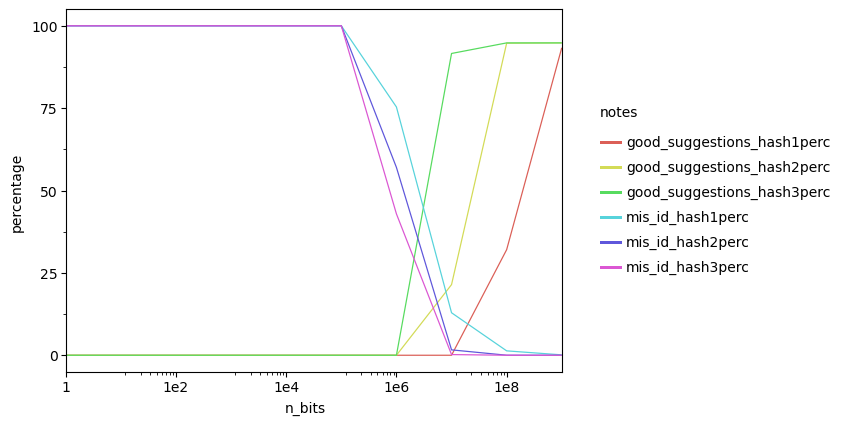

In [222]:
#plotting percentage_vs_n_bits
percentage_vs_n_bits=(ggplot(plot_dataframe1, aes(x='n_bits', y='percentage',color = 'notes'))
 +geom_line()
 +scale_x_continuous(trans='log10',expand=(0,0))
 +theme_matplotlib()
)
print(percentage_vs_n_bits)

In [223]:
# annotations for percentage_vs_n_bits:
# good_suggestions_hash1perc represents the percentage of good suggestions when using one hash function
# good_suggestions_hash2perc represents the percentage of good suggestions when using two hash functions
# good_suggestions_hash3perc represents the percentage of good suggestions when using three hash functions
# while: mis_id_hash1perc represents the percentage of misidentifications when using one hash function
# mis_id_hash2perc represents the percentage of misidentifications when using two hash functions
# mis_id_hash3perc represents the percentage of misidentifications when using three hash functions